In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
import os
import pickle
import random
from collections import Counter

import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

## Select code blocks taken from Syed's CellOT experiments

### Load data

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

In [3]:
path = "/home/dor3/cell2sentence/cross_species/Syed_CellOT_Code/datasets/harmony_common_pancreas_20241025.h5ad"
adata = anndata.read_h5ad(path)
adata

AnnData object with n_obs × n_vars = 9436 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'
    var: 'homolog_pair_idx', 'human_gene_name', 'mouse_gene_name', 'human_gene_ensembl_id', 'mouse_gene_ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'pca', 'species_label_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony_library', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
mpl.rcParams['figure.facecolor'] = 'white'

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


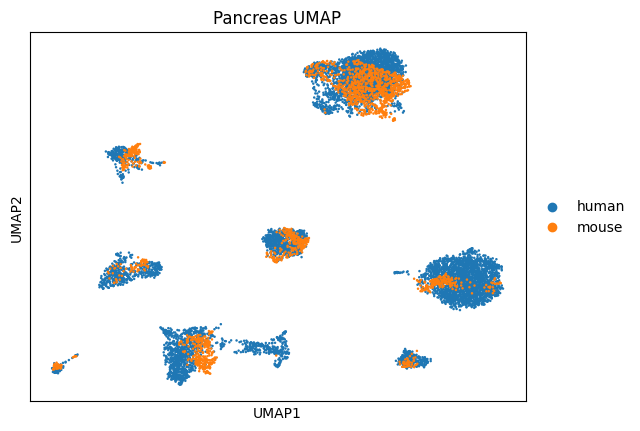

In [5]:
sc.pl.umap(
    adata,
    color="species_label",
    use_raw=False,
    layer="X_umap",
    title="Pancreas UMAP"
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


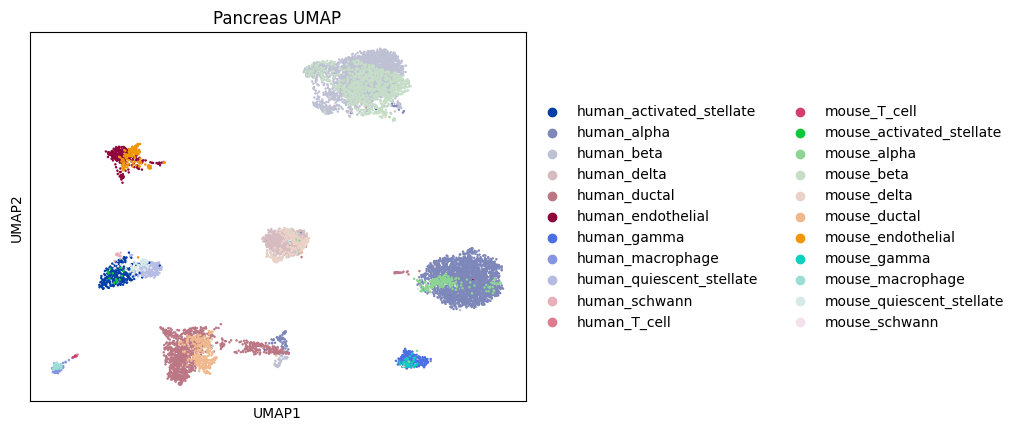

In [6]:
sc.pl.umap(
    adata,
    color="species_cell_type_label",
    use_raw=False,
    layer="X_umap",
    title="Pancreas UMAP"
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


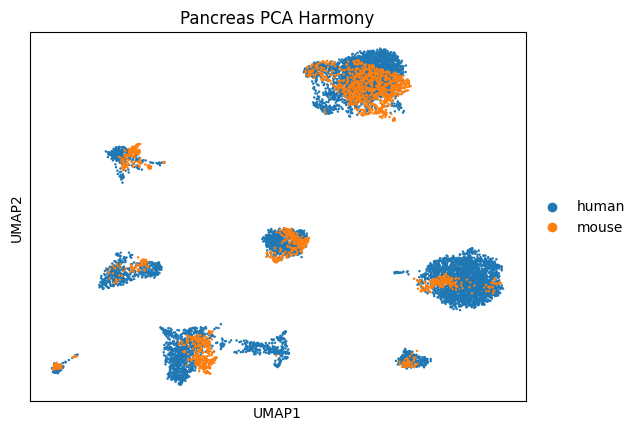

In [7]:
sc.pl.umap(
    adata,
    color="species_label",
    use_raw=False,
    layer="X_pca_harmony_library",
    title="Pancreas PCA Harmony"
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


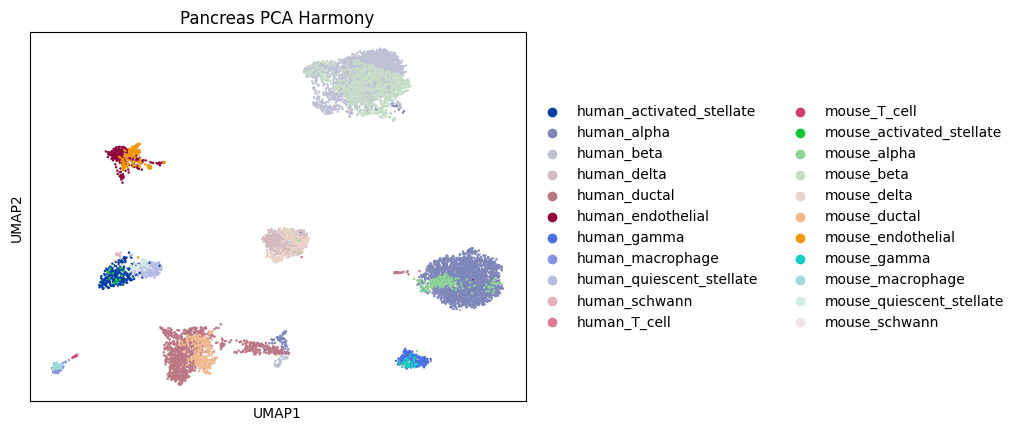

In [8]:
sc.pl.umap(
    adata,
    color="species_cell_type_label",
    use_raw=False,
    layer="X_pca_harmony_library",
    title="Pancreas PCA Harmony"
)

In [9]:
adata.obsm["X_pca_harmony_library"][:5, :5]

array([[ 4.86918897, -4.24895634, -0.85494877,  1.52120728, -1.51291382],
       [ 2.52879507, -1.27629558,  0.12428052, -2.14126859,  0.47549476],
       [ 0.67772657,  1.0425095 , -0.33542794, -3.17698141, -0.89548378],
       [ 4.08769061, -4.58518686, -0.65771514,  0.11044979, -0.3882161 ],
       [-9.54956369, -4.66992219, 10.56169994,  0.98726691, -1.6254936 ]])

In [10]:
adata.obsm["X_umap"][:5, :5]

array([[ 7.7665625, 20.553509 ],
       [ 3.9344935,  7.0906754],
       [ 4.04661  ,  5.912176 ],
       [ 7.158471 , 18.904852 ],
       [-7.3787045,  3.7349594]], dtype=float32)

In [11]:
print(adata.obsm["X_pca_harmony_library"].shape)
print(adata.obsm["X_umap"].shape)

(9436, 50)
(9436, 2)


In [12]:
Counter(adata.obs["species_label"])

Counter({'human': 7568, 'mouse': 1868})

In [13]:
adata.X

<9436x12113 sparse matrix of type '<class 'numpy.float32'>'
	with 15443599 stored elements in Compressed Sparse Row format>

In [14]:
adata.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,species_cell_type_label,species_label
human1_lib1.final_cell_0007,AAAATCGTT-CTCCGCAT,human1_lib1.final_cell_0007,beta,GSM2230757_human1_umifm_counts,3843,3843,14947.0,0.0,0.0,human_beta,human
human1_lib1.final_cell_0013,AAAATCGTT-GGAAACAG,human1_lib1.final_cell_0013,delta,GSM2230757_human1_umifm_counts,2357,2357,8338.0,0.0,0.0,human_delta,human
human1_lib1.final_cell_0014,GATTGAGGGT-CTGGTGCA,human1_lib1.final_cell_0014,delta,GSM2230757_human1_umifm_counts,2191,2191,8155.0,0.0,0.0,human_delta,human
human1_lib1.final_cell_0015,AAAGTAATC-TCGGTTCG,human1_lib1.final_cell_0015,beta,GSM2230757_human1_umifm_counts,3547,3547,13633.0,0.0,0.0,human_beta,human
human1_lib1.final_cell_0016,AAATGAATG-ACGGTAGC,human1_lib1.final_cell_0016,activated_stellate,GSM2230757_human1_umifm_counts,3585,3584,13091.0,0.0,0.0,human_activated_stellate,human


In [15]:
adata.var.head()

,homolog_pair_idx,human_gene_name,mouse_gene_name,human_gene_ensembl_id,mouse_gene_ensembl_id,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
homolog_pair_0,homolog_pair_0,EIF1AY,EIF1A,ENSG00000198692,ENSMUSG00000057561,False,0.206266,0.237153,-0.814190,0,False
homolog_pair_1,homolog_pair_1,COLEC12,COLEC12,ENSG00000158270,ENSMUSG00000036103,False,0.002203,0.255495,-0.376221,1,False
homolog_pair_2,homolog_pair_2,IMPA2,IMPA2,ENSG00000141401,ENSMUSG00000024525,True,0.256580,0.891616,0.724113,4,False
homolog_pair_3,homolog_pair_3,RAB31,RAB31,ENSG00000168461,ENSMUSG00000056515,True,0.262541,1.046294,1.093602,5,False
homolog_pair_4,homolog_pair_4,MED15,MED15,ENSG00000099917,ENSMUSG00000012114,False,0.193046,0.342892,-0.372020,0,False


# Legacy code below (the code below is not in use)

In [3]:
# Construct the path to the target directory and file
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
target_directory = os.path.join(parent_directory, "Daphne CellOT Files")
os.makedirs(target_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Define the full file path
file_path = os.path.join(target_directory, "harmony_common_pancreas.h5ad")

# Check if the file exists
if os.path.exists(file_path):
    # Load the AnnData object from the file
    combined_adata = anndata.read_h5ad(file_path)
    print(f"Loaded AnnData object from {file_path}")
else:
    # load processed AnnData object
    combined_adata = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_preprocessed_joint_adata.h5ad")

    # Identify highly variable genes with respect to batches
    batch_key = 'batch_sample'  # Adjust this key based on your specific batch information
    sc.pp.highly_variable_genes(combined_adata, batch_key=batch_key, flavor='seurat', n_top_genes=2000)

    # Add missing columns for highly variable genes
    if 'highly_variable_nbatches' not in combined_adata.var:
        combined_adata.var['highly_variable_nbatches'] = np.sum(combined_adata.var.highly_variable, axis=1)

    if 'highly_variable_intersection' not in combined_adata.var:
        combined_adata.var['highly_variable_intersection'] = combined_adata.var['highly_variable']

    # Run PCA on the combined AnnData
    sc.pp.pca(combined_adata)

    # Correct for batch effects using Harmony
    sc.external.pp.harmony_integrate(combined_adata, batch_key)

    # Compute the neighborhood graph
    sc.pp.neighbors(combined_adata, use_rep='X_pca_harmony')

    # Run UMAP
    sc.tl.umap(combined_adata)

    # Write the combined data to a file
    # Construct the path to the target directory and file
    current_directory = os.getcwd()
    parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
    target_directory = os.path.join(parent_directory, "Daphne CellOT Files")
    os.makedirs(target_directory, exist_ok=True)  # Create the directory if it doesn't exist

    # Define the full file path
    file_path = os.path.join(target_directory, "harmony_common_pancreas.h5ad")

    # Assuming `adata` is your AnnData object
    combined_adata.write(file_path)

    # Print confirmation
    print(f"AnnData object saved to {file_path}")

# Print confirmation of the current adata object
print(combined_adata)
        



/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in divide
  df["dispersions_norm"] = (
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in divide
  df["dispersions_norm"] = (
/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: RuntimeWarning: invalid value encountered in divide
  df["dispersions_norm"] = (


                highly_variable  highly_variable_nbatches  \
homolog_pair_0            False                         0   
homolog_pair_1            False                         1   
homolog_pair_2             True                         4   
homolog_pair_3             True                         5   
homolog_pair_4            False                         0   

                highly_variable_intersection  
homolog_pair_0                         False  
homolog_pair_1                         False  
homolog_pair_2                         False  
homolog_pair_3                         False  
homolog_pair_4                         False  


2024-11-19 20:42:13,584 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-19 20:42:16,892 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-19 20:42:16,924 - harmonypy - INFO - Iteration 1 of 10
2024-11-19 20:42:18,890 - harmonypy - INFO - Iteration 2 of 10
2024-11-19 20:42:21,037 - harmonypy - INFO - Iteration 3 of 10
2024-11-19 20:42:22,908 - harmonypy - INFO - Iteration 4 of 10
2024-11-19 20:42:24,884 - harmonypy - INFO - Iteration 5 of 10
2024-11-19 20:42:26,574 - harmonypy - INFO - Iteration 6 of 10
2024-11-19 20:42:27,990 - harmonypy - INFO - Iteration 7 of 10
2024-11-19 20:42:29,030 - harmonypy - INFO - Iteration 8 of 10
2024-11-19 20:42:30,120 - harmonypy - INFO - Iteration 9 of 10
2024-11-19 20:42:31,203 - harmonypy - INFO - Converged after 9 iterations


AnnData object saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Daphne CellOT Files/harmony_common_pancreas.h5ad
AnnData object with n_obs × n_vars = 10455 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'
    var: 'homolog_pair_idx', 'human_gene_name', 'mouse_gene_name', 'human_gene_ensembl_id', 'mouse_gene_ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_types_colors', 'neighbors', 'pca', 'species_label_colors', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


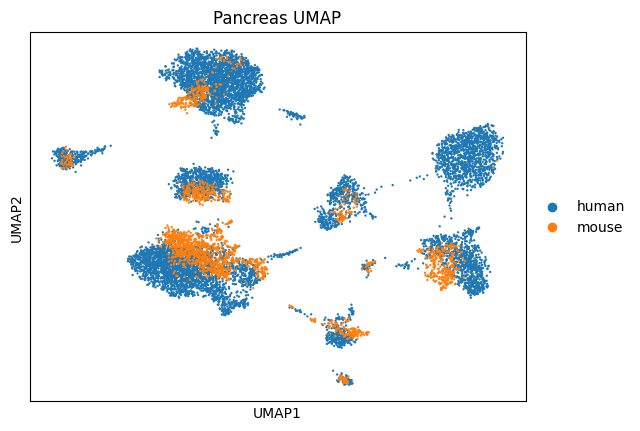

In [4]:
sc.pl.umap(
    combined_adata,
    color="species_label",
    use_raw=False,
    layer="X_umap",
    title="Pancreas UMAP"
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


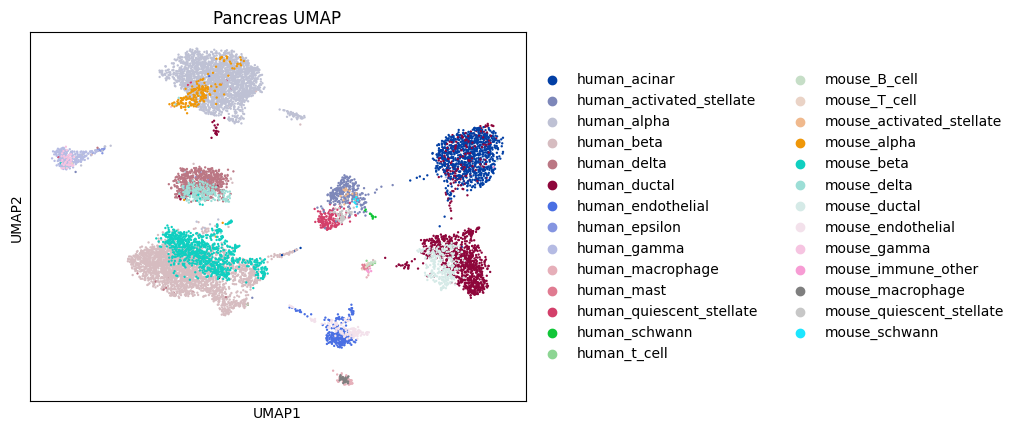

In [5]:
sc.pl.umap(
    combined_adata,
    color="species_cell_type_label",
    use_raw=False,
    layer="X_umap",
    title="Pancreas UMAP"
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


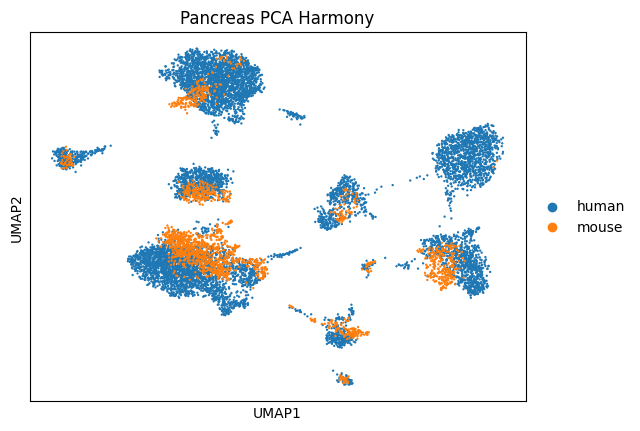

In [6]:
sc.pl.umap(
    combined_adata,
    color="species_label",
    use_raw=False,
    layer="X_pca_harmony",
    title="Pancreas PCA Harmony"
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


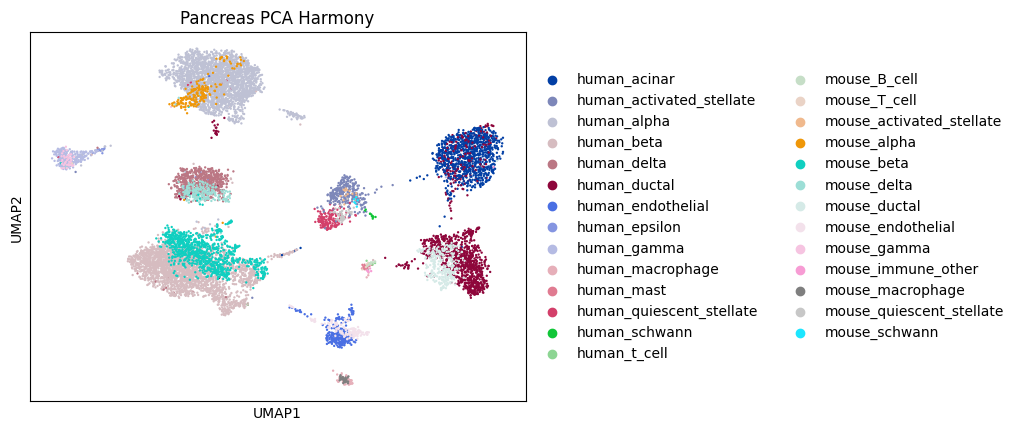

In [7]:
sc.pl.umap(
    combined_adata,
    color="species_cell_type_label",
    use_raw=False,
    layer="X_pca_harmony",
    title="Pancreas PCA Harmony"
)

In [8]:
combined_adata.obsm["X_pca_harmony"][:5, :5]

array([[ 7.872984  , -2.34846   ,  0.2610291 ,  0.17428954,  0.2520048 ],
       [ 8.198186  , -1.2548335 ,  0.3399528 , -1.0903926 , -0.18608363],
       [ 7.928614  , -2.7199607 ,  0.14189535,  0.30561626,  0.37949485],
       [ 8.158575  , -1.44687   ,  0.4452163 , -0.9310918 , -0.0537358 ],
       [ 7.607334  , -1.2210503 ,  0.34590477, -0.6432715 ,  0.02374936]],
      dtype=float32)

In [9]:
combined_adata.obsm["X_umap"][:5, :5]

array([[14.043752,  9.819547],
       [11.951826,  8.833523],
       [12.59623 , 10.60973 ],
       [11.890131,  9.505344],
       [12.798475,  8.67601 ]], dtype=float32)

In [10]:
print(combined_adata.obsm["X_pca_harmony"].shape)
print(combined_adata.obsm["X_umap"].shape)

(10455, 50)
(10455, 2)


In [11]:
Counter(combined_adata.obs["species_label"])

Counter({'human': 8569, 'mouse': 1886})

In [12]:
combined_adata.X

<10455x12113 sparse matrix of type '<class 'numpy.float32'>'
	with 17178554 stored elements in Compressed Sparse Row format>

In [13]:
combined_adata.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,species_cell_type_label,species_label
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0,human_acinar,human
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0,human_acinar,human
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0,human_acinar,human
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0,human_acinar,human
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0,human_acinar,human


In [14]:
combined_adata.var.head()

,homolog_pair_idx,human_gene_name,mouse_gene_name,human_gene_ensembl_id,mouse_gene_ensembl_id,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
homolog_pair_0,homolog_pair_0,EIF1AY,EIF1A,ENSG00000198692,ENSMUSG00000057561,False,0.069323,-0.997422,-0.755563,0,False
homolog_pair_1,homolog_pair_1,COLEC12,COLEC12,ENSG00000158270,ENSMUSG00000036103,False,0.000704,-0.693991,-0.118897,1,False
homolog_pair_2,homolog_pair_2,IMPA2,IMPA2,ENSG00000141401,ENSMUSG00000024525,True,0.092954,-0.603601,0.574109,4,False
homolog_pair_3,homolog_pair_3,RAB31,RAB31,ENSG00000168461,ENSMUSG00000056515,True,0.079748,-0.498244,0.992624,5,False
homolog_pair_4,homolog_pair_4,MED15,MED15,ENSG00000099917,ENSMUSG00000012114,False,0.066131,-0.918829,-0.502386,0,False
